<a href="https://colab.research.google.com/github/PinChunPai/Cat_breeds_classification/blob/main/colab/Cat_breeds_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cat breeds classification**
This is a side project for computer vision, using the famous Stanford dog dataset. In this project I would like to use the pre-trained vit from google to train a cat-breed-claasification model by transfer learning. Goggle vit conatins 7 breeds of cats in its 1000 calsses. We are going to use a dataset from Kaggle labeling 67 breeds. So it's a good test of how pre-trained model can be improved by fine-tuning.
The model will be posted to hugging space so everyone can use it on-line.

## **Steps**
This project contains the following steps:
1. Access data: I will download the data from Kaggle and store it in my colud derive.
2. EDA
3. train-test split to get three datasets: train_ds, valid_ds and test_ds
4. Install pre-trained vision transformer model and clarify how to prepare data for it
5. Using the information from step 4, construct two different transformations. They account for:
* Resize, augement, to_tensor and normalize train_ds
* Resize and normalize test_ds and valid_ds
6. Construct relevant dataloaders
7. Define fine-tuned model
8. Train model and fine tune parameters
9. Train model on all availale labelled datas to get the maximum information.
10.Upload model to Hugging face and Gradio.  


## **Setup**
Firstly, we import and install packages which will be used later. Start from fundamental commands for i/o, algebra and drawing.

In [112]:
## Fundamental packages for reading/writing files, algebra and plot
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 ### used for reading/writing images
import warnings
warnings.filterwarnings("ignore") ## ignore annoying warnings
from sklearn.model_selection import train_test_split ## For data preprocess

Then we import torch and relative packages used fo preprocess and load image datas

In [113]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

Now we install three packages:
* transformer: to use pre-trained vision transformer models
* evaluate: to provide various metrics to evaluate models
* gradio: to establish web demo

I am going to fix the version so I can use what I learn from class without worrying about version issues.

In [114]:
!pip install transformers==4.24.0
!pip install evaluate==0.3.0
!pip install gradio==3.12.0

## **1.Get data**
The dataset is stored in my google derive. So I define the relevant path for my derive. **This part should be modified on different enviroments.**

In this project I am going to use a cat breed dataset downloaded from [this Kaggle page](https://www.kaggle.com/datasets/knucharat/pop-cats). However the resourse can be tracked back to another [Petfinder](https://www.petfinder.com/developers/) \(available through [petpy](https://github.com/aschleg/petpy) \). The set I use in this project has been cleaned and it contains 20 common breeds, each containing 500 pictures. I further integrate the data and stored the reult in labels.csv.



In [115]:
path = '/content/drive/MyDrive/Project/Transformer_CV' ## It should be modified to the ACTUAL PATH storing dataset.

In [116]:
ls /content/drive/MyDrive/Project/Transformer_CV

Cat_breeds_basic.ipynb  cats20/  create_list.ipynb  labels.csv  models/  results/


There are three objects being used:
* Cat_breeds.ipynb : This Colab file.
* cats20/ : The folder containing all labeled jpg pictures.
* labels.csv: Csv file storing ids for each image and corresponding labels.

create_list.ipynb is what I designed to interate data and the result is stored in labels.csv. It won't be used in the following code.


Let's take a look at labels.csv, which stores useful information.

In [117]:
all_data = pd.read_csv(os.path.join(path, 'labels.csv'))
all_data.head(5)

,id,breed
0,munchkin_478.jpg,Munchkin / 曼赤肯貓
1,americancurl_329.jpg,American Curl / 美國卷耳貓
2,birman_61.jpg,Birman / 伯曼貓
3,russianblue_199.jpg,Russian Blue / 俄羅斯藍貓
4,munchkin_429.jpg,Munchkin / 曼赤肯貓


It provides names of pictures and the corresponding labels. Let's convert 'id' to the actually path.

In [118]:
all_data['id'] = path + '/cats20/' + all_data['id']
all_data.head(5)

,id,breed
0,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓
1,/content/drive/MyDrive/Project/Transformer_CV/...,American Curl / 美國卷耳貓
2,/content/drive/MyDrive/Project/Transformer_CV/...,Birman / 伯曼貓
3,/content/drive/MyDrive/Project/Transformer_CV/...,Russian Blue / 俄羅斯藍貓
4,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓


## **2. EDA**
'id' of each row is exactly the name of each picture. Using them we can read pictures from corresponding folders.

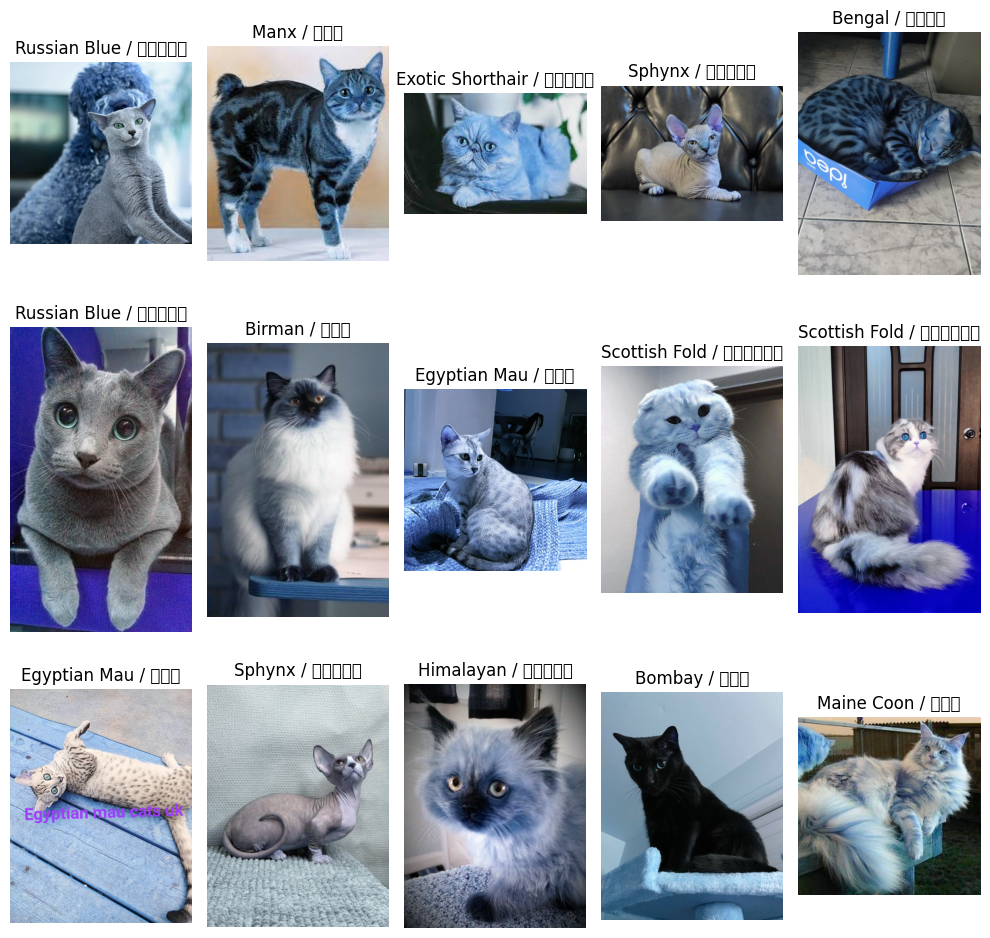

In [119]:
samples = all_data.sample(15)
plt.figure(figsize=(10, 10))

for i, index in enumerate(samples.index):
    plt.subplot(3,5, i + 1)
    img = cv2.imread(samples.loc[[index], "id"].values[0] )
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{samples.loc[[index],"breed"].values[0]}')

plt.tight_layout()
plt.show()

Notice that the sizes of pictures are different. They need to be resized in preprocessing step.

Before preprocessing, let's take a look at how the target feature(breed in this case) distributes.

In [120]:
all_data['breed'].value_counts()

Bombay / 孟買貓                  502
Birman / 伯曼貓                  502
American Curl / 美國卷耳貓         501
Siamese / 暹羅貓                 501
Persian / 波斯貓                 501
Sphynx / 斯芬克斯貓                501
Egyptian Mau / 埃及貓            501
Bengal / 孟加拉貓                 501
Abyssinian / 阿比尼西亞貓           501
Maine Coon / 緬因貓              501
Munchkin / 曼赤肯貓               501
Himalayan / 喜馬拉雅貓             501
Ragdoll / 布偶貓                 501
Scottish Fold / 蘇格蘭摺耳貓        501
Exotic Shorthair / 異國短毛貓      501
Russian Blue / 俄羅斯藍貓          501
Manx / 曼島貓                    501
American Shorthair / 美國短毛貓    500
Norwegian Forest / 挪威森林貓      500
Bristish Shorthair / 英國短毛貓    500
Name: breed, dtype: int64

We see that the distribution is not too imbalanced. Totally 120 breeds and max_num ~ 2* min_num. We can plot the value counts.

<Axes: >

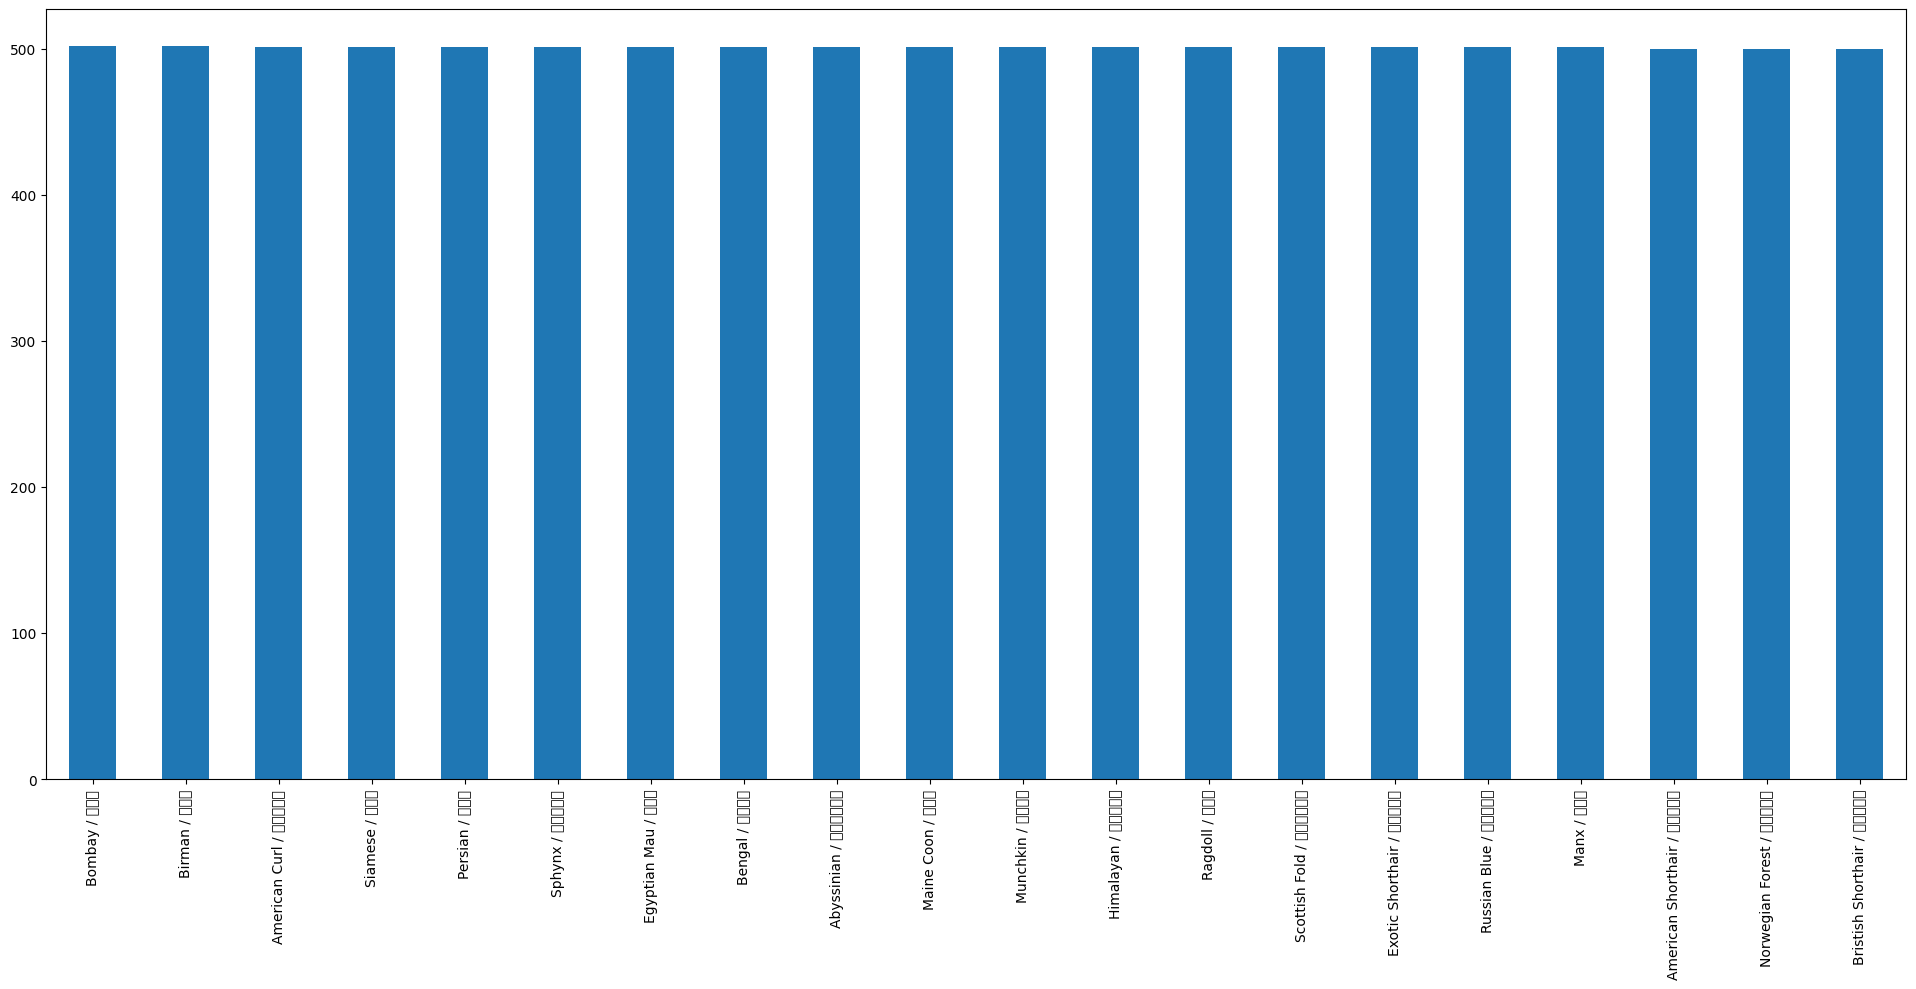

In [121]:
all_data['breed'].value_counts().plot.bar(figsize=(24,10))

Let encode breeds to number tokens. To do so, we have to construct two maps. One for encoding breeds to tokens and one for decoding tokens to breeds.

In [122]:
breeds = all_data.breed.unique()
id2label = {i: label for i, label in enumerate(breeds)}
label2id = {v: k for k, v in id2label.items()}

In [123]:
all_data['labels'] = all_data['breed'].map(label2id)

Therefore we don't need to worry about distribution. We can use train_test_split to get training, validation and testing set.

In [124]:
y = all_data['breed'].to_frame()
train_val, test_data, y_train_val, y_test = train_test_split(all_data.drop("breed",axis =1), y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=0.11, random_state=42, shuffle=True, stratify=y_train_val)

In [125]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


(8025, 2)
(992, 2)
(1002, 2)


## **Pre-Trained Model**
Before going to data preprocessing, we should take a look at the pre-trained model. Especially we want to look at format of its input and what it was trained for.



### **Install**
I will use vit provided by google, which is open sourced on [HuggingFace]()

In [126]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

model_id = 'google/vit-base-patch16-224'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(model_id).to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [127]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

It does normalize and resize automatically. But we may still want to address these process by ourselves so that we can do experiments later.

### **Test Pre-trained Model**

Take a random picture to test this pre-trained model.

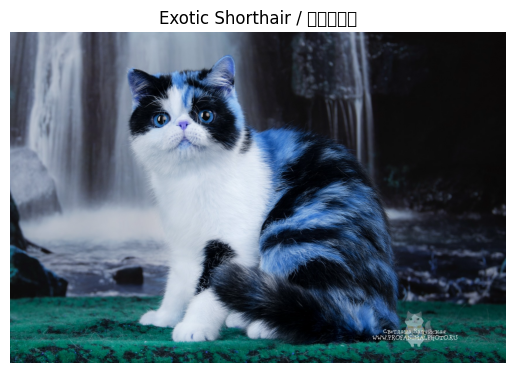

In [128]:
img = cv2.imread(all_data.loc[[3358], "id"].values[0] )
plt.imshow(img)
plt.axis('off')
plt.title(f'{all_data.loc[[3358],"breed"].values[0]}')
plt.show()

In [129]:
inp = feature_extractor(img, return_tensors="pt").to(device)

In [130]:
print(type(inp))

<class 'transformers.feature_extraction_utils.BatchFeature'>


In [131]:
oput = model(**inp)

In [132]:
oput.logits.shape

torch.Size([1, 1000])

In [133]:
torch.argmax(oput.logits, dim=1)

tensor([664], device='cuda:0')

Using "model.config" we can see that google vit already contains 7 breeds of cat (281-287). There are only 3 breeds in our 20 targets: Persian, Egyptian and Siamese. Therefore it's a good chance to test how fine tuning can help us improve pre-tranined model.

In [134]:
model.config.id2label[283]

'Persian cat'

We see that pre-trained model does a good work: it realizes it's a cat instead of other objects. However we can definitely improve it since our task it to classify breeds and the result is not correct yet. Befor proceeding let's check how well the pre-trained model can do.

In [135]:
for i in range(20):
  print(f'{275+i}: {model.config.id2label[275+i]}')

275: African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus
276: hyena, hyaena
277: red fox, Vulpes vulpes
278: kit fox, Vulpes macrotis
279: Arctic fox, white fox, Alopex lagopus
280: grey fox, gray fox, Urocyon cinereoargenteus
281: tabby, tabby cat
282: tiger cat
283: Persian cat
284: Siamese cat, Siamese
285: Egyptian cat
286: cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
287: lynx, catamount
288: leopard, Panthera pardus
289: snow leopard, ounce, Panthera uncia
290: jaguar, panther, Panthera onca, Felis onca
291: lion, king of beasts, Panthera leo
292: tiger, Panthera tigris
293: cheetah, chetah, Acinonyx jubatus
294: brown bear, bruin, Ursus arctos


As we see, pre-trained model contains 5 breeds of cat (id: 281~285). Three among them are part of our 20 breeds. Some of them match the previous 15 samples so let's take a futher test.

In [136]:
for i, index in enumerate(samples.index):
    img = cv2.imread( samples.loc[[index], "id"].values[0] )
    oput = model(**feature_extractor(img, return_tensors="pt").to(device))
    print(f'{samples.loc[[index],"breed"].values[0]} ->  {model.config.id2label[torch.argmax(oput.logits, dim=1).item()]}')

Russian Blue / 俄羅斯藍貓 ->  Egyptian cat
Manx / 曼島貓 ->  tabby, tabby cat
Exotic Shorthair / 異國短毛貓 ->  Persian cat
Sphynx / 斯芬克斯貓 ->  Egyptian cat
Bengal / 孟加拉貓 ->  Egyptian cat
Russian Blue / 俄羅斯藍貓 ->  Egyptian cat
Birman / 伯曼貓 ->  Persian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Scottish Fold / 蘇格蘭摺耳貓 ->  teddy, teddy bear
Scottish Fold / 蘇格蘭摺耳貓 ->  Persian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Sphynx / 斯芬克斯貓 ->  Mexican hairless
Himalayan / 喜馬拉雅貓 ->  Persian cat
Bombay / 孟買貓 ->  swab, swob, mop
Maine Coon / 緬因貓 ->  Persian cat


We see that google vit recognizes cats quite well -- most of them are identified as cats. This means our training data is good and google vit does catch characters of cats.

Now let's see how the pre-trained model performs among the three breeds existing in its output. We take 12 samples to catch the basic idea.

In [137]:
three_breeds_samples = all_data[all_data.breed.isin(['Persian / 波斯貓', 'Egyptian Mau / 埃及貓', 'Siamese / 暹羅貓'])].sample(25)
#plt.figure(figsize=(10, 10))
for i, index in enumerate(three_breeds_samples.index):
    img = cv2.imread(three_breeds_samples.loc[[index], "id"].values[0] )
    '''
    plt.subplot(4,5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Breed: {three_breeds_samples.loc[[index],"breed"].values[0]}')
    '''
    oput = model(**feature_extractor(img, return_tensors="pt").to(device))
    print(f'{three_breeds_samples.loc[[index],"breed"].values[0]} ->  {model.config.id2label[torch.argmax(oput.logits, dim=1).item()]}')
#plt.tight_layout()
#plt.show()

Egyptian Mau / 埃及貓 ->  Egyptian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Persian / 波斯貓 ->  Persian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Persian / 波斯貓 ->  ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
Siamese / 暹羅貓 ->  Egyptian cat
Persian / 波斯貓 ->  Persian cat
Siamese / 暹羅貓 ->  Siamese cat, Siamese
Egyptian Mau / 埃及貓 ->  Egyptian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Persian / 波斯貓 ->  Persian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Egyptian Mau / 埃及貓 ->  rocking chair, rocker
Persian / 波斯貓 ->  Persian cat
Siamese / 暹羅貓 ->  Siamese cat, Siamese
Siamese / 暹羅貓 ->  Siamese cat, Siamese
Persian / 波斯貓 ->  Persian cat
Persian / 波斯貓 ->  Angora, Angora rabbit
Egyptian Mau / 埃及貓 ->  Egyptian cat
Persian / 波斯貓 ->  Persian cat
Egyptian Mau / 埃及貓 ->  Egyptian cat
Persian / 波斯貓 ->  doormat, welcome mat
Persian / 波斯貓 ->  Persian cat


It's not bad for this three breeds! The accuracy is 80~85 % for this three breeds and most pictures are classified as cat (5 among 1000 possibilities). It provides a good starting point for further fine-tune.

## **Preprocessing**
Since I am going to use google vit as pre-trained model, every input must fit the format of google vit. As we saw in the last section, google vit has a bulit-in preprocess to read different size of pictures. Despite the convenience, I will do preprocessing by myself because of the following reasons:
1. I want to train a model providing better results than google vit did in this specific task. Customed preprocessing allows us to try different strategies.
2. As a side project, I want to make sure that I am familiar with all necessary steps and understand how every part could impact the final result.

### **transform**

Let's look what does feature_extractor do.

In [138]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [139]:
input_size =feature_extractor.size
mean = feature_extractor.image_mean
std = feature_extractor.image_std
print(input_size,mean, std)

224 [0.5, 0.5, 0.5] [0.5, 0.5, 0.5]


As showed above, feature_extractor is designed to resize pictures to 224*224 and normalize them. We can define transform to implement these operations. torchvision provides many useful functions including resize, renormalize and various augment methods. As the basic attempt, I will define two transformer: one for training data and one for validation/testing data. Transform for training data contains additional augment operations while testing-transform only does what feature_extractor does. However, I will try some experiment in the next version.

In [140]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

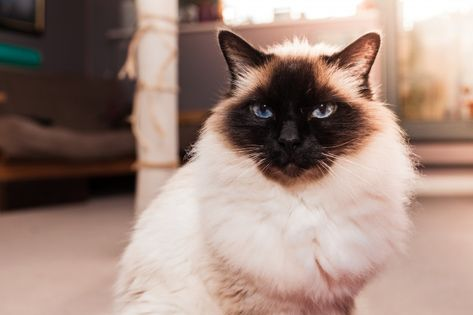

In [141]:
sample_img = Image.open(all_data.loc[[3720], "id"].values[0] )
sample_img

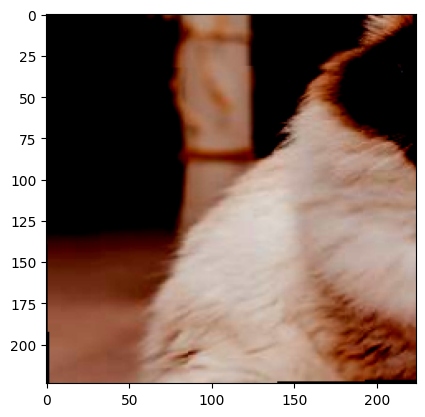

In [142]:
transformed_sample = train_transform(sample_img)
plt.imshow(transformed_sample.permute(1,2,0))
plt.show()

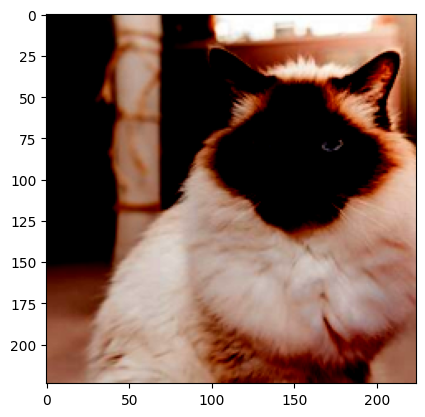

In [143]:
test_transformed_sample = test_transform(sample_img)
plt.imshow(test_transformed_sample.permute(1,2,0))
plt.show()

### **Dataset/Dataloader**
From [vit document](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) one can see that "pixel_values" and "labels" are two necessary inputs we should provide. Let's define dataset for following operations:
1. from input dataframe['id'] extract path and read image
2. transform images, the resultf will be in "pixel_values" column
3. from input dataframe['breed'] extract label and store it to gpu
4. return {"pixel_values":image, "labels",label}


In [168]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.data)  # Number of images
    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'id']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.data.loc[idx, 'labels'], dtype=torch.long).to(device)  # Move label to GPU
        return {"pixel_values": image, "labels": label}

Let's check whether it works.

In [145]:
check_data = train_data.sample(30)

In [146]:
check_train_dataset = CustomImageDataset(check_data, transform=train_transform)
check_train_dataset[0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor(8, device='cuda:0')}

In [147]:
check_data.head(5)

,id,labels
812,/content/drive/MyDrive/Project/Transformer_CV/...,8
5445,/content/drive/MyDrive/Project/Transformer_CV/...,8
7200,/content/drive/MyDrive/Project/Transformer_CV/...,4
625,/content/drive/MyDrive/Project/Transformer_CV/...,18
7248,/content/drive/MyDrive/Project/Transformer_CV/...,4


In [148]:
check_train_dataset[0]['pixel_values'].shape

torch.Size([3, 224, 224])

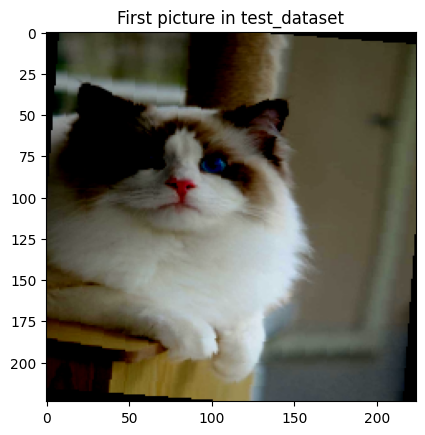

In [149]:
plt.imshow(check_train_dataset[0]['pixel_values'].permute(1,2,0))
plt.title('First picture in test_dataset')
plt.show()

It works! Let's check whether test_transform works as well

In [150]:
check_test_dataset = CustomImageDataset(check_data, transform=test_transform)

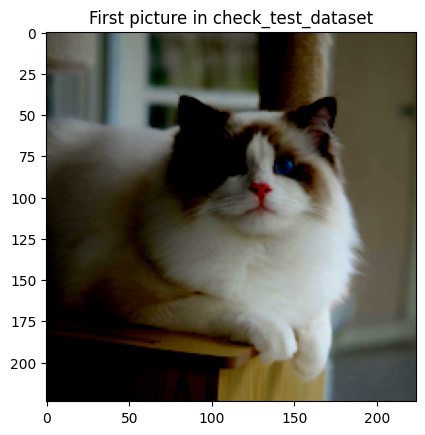

In [151]:
plt.imshow(check_test_dataset[0]['pixel_values'].permute(1,2,0))
plt.title('First picture in check_test_dataset')
plt.show()

Now we can prepare dataloader for training, validation and testing data. Some hyperparameters such as batch size and prefetch factor should be tested later.

In [152]:
train_dataset = CustomImageDataset(train_data, transform=train_transform)
val_dataset = CustomImageDataset(val_data, transform=test_transform)
test_dataset = CustomImageDataset(test_data, transform=test_transform)

Let's construct another smaller dataloader for testing in the foloowing sections.

In [153]:
check_val_dataset = CustomImageDataset(val_data.sample(30), transform=test_transform)

In [165]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

check_train_dataloader = DataLoader(check_train_dataset, batch_size=5, shuffle=True, num_workers=0)
check_val_dataloader = DataLoader(check_val_dataset, batch_size=5, shuffle=False, num_workers=0)


## **Define model**

Now we can define the fine tune model. There are various approaches we can try:
1. Replace model's id2label and label2id by our customered maps and then train the moel again. This may cost a lot of time but in principle it should provide the best result.

2. Remove the last layer and fix the pretrained model, and then use its result to be the input of a smaller custimered NN. This would be more efficient if the pre-trained model already learn important features of cats from ImageNet.

3. The middle choice is to keep most parameters of pretrained model and then train some of its last layers along with our customered NN. A good choice of training amount should balance model cost and model ability.   

I will try approach 1 first to get the sense of how much cost for training all parameters of google vit. However it seems reasonable to use approach 2 or 3 because in **Pre-Trained Model** section we saw that google vit catches a good basic sense of cats.

In [171]:
fine_tune_model = AutoModelForImageClassification.from_pretrained(model_id,
                                                                  num_labels=len(breeds),
                                                                  id2label=id2label,
                                                                  label2id=label2id,
                                                                  ignore_mismatched_sizes=True
                                                                  ).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Training**

To implement training process we will need following components:
1. Loss function
2. Optimizer
3. Metric to evaluate
4. Hyperparameter such as epoch numbers and learning rates.

Again, there is a lot of choices and combinations and the most relevant value should be determined by trying. Before we dig into all these endless tuning, let's construct a smaller trainer and check it works.


### **Fundamental Test**

In [156]:
from transformers import TrainingArguments, Trainer, DataCollator
from datasets import load_metric
import tensorboard


In [157]:
def collate_fn(batch):  ## reference: https://juejin.cn/post/7238148905095839804
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [158]:
#!mkdir -p /content/drive/MyDrive/Project/Transformer_CV/models

In [159]:
'''
test_args = TrainingArguments(
    #output_dir="/content/drive/MyDrive/Project/Transformer_CV/models",
    num_train_epochs=10,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    warmup_steps=20,
    logging_steps=10,
    evaluation_strategy='steps',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    report_to="tensorboard",
    push_to_hub=False
)
'''

'\ntest_args = TrainingArguments(\n    #output_dir="/content/drive/MyDrive/Project/Transformer_CV/models",\n    num_train_epochs=10,\n    per_device_train_batch_size=5,\n    per_device_eval_batch_size=5,\n    warmup_steps=20,\n    logging_steps=10,\n    evaluation_strategy=\'steps\',\n    learning_rate=2e-5,\n    load_best_model_at_end=True,\n    remove_unused_columns=False,\n    report_to="tensorboard",\n    push_to_hub=False\n)\n'

In [160]:
'''
test_trainer = Trainer(
    model=fune_tune_model,
    args=test_args,
    train_dataset=check_train_dataset,
    eval_dataset=check_val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)
test_trainer.train()
'''

'\ntest_trainer = Trainer(\n    model=fune_tune_model,\n    args=test_args,\n    train_dataset=check_train_dataset,\n    eval_dataset=check_val_dataset,\n    data_collator=collate_fn,\n    compute_metrics=compute_metrics\n)\ntest_trainer.train()\n'

### **Model training**

Now we see it works. So it's time to train our train_dataset in real. We construct the svae paths firstly.

In [161]:
#!mkdir -p /content/drive/MyDrive/Project/Transformer_CV/models/basic_model
#!mkdir -p /content/drive/MyDrive/Project/Transformer_CV/models/basic_model/logs

In [162]:
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Project/Transformer_CV/models/basic_model",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=200,
    logging_dir="/content/drive/MyDrive/Project/Transformer_CV/models/basic_model/logs",  # Specify a directory for TensorBoard logs
    logging_steps=100,
    save_steps=100,
    eval_steps=100,
    evaluation_strategy='steps',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    report_to="tensorboard",
    push_to_hub=False,
   # hub_model_id = "PinChunPai/Cat_breeds-model"
)

In [163]:
'''
trainer = Trainer(
    model=fune_tune_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)
'''

'\ntrainer = Trainer(\n    model=fune_tune_model,\n    args=args,\n    train_dataset=train_dataset,\n    eval_dataset=val_dataset,\n    data_collator=collate_fn,\n    compute_metrics=compute_metrics\n)\n'

Epoch 1/10, Train Loss: 2.9372081756591797, Val Loss: 3.1021639506022134, Accuracy: 0.03333333333333333
Epoch 2/10, Train Loss: 3.222139835357666, Val Loss: 3.101741075515747, Accuracy: 0.03333333333333333
Epoch 3/10, Train Loss: 3.395514965057373, Val Loss: 3.10125466187795, Accuracy: 0.03333333333333333
Epoch 4/10, Train Loss: 3.3226935863494873, Val Loss: 3.100916862487793, Accuracy: 0.03333333333333333
Epoch 5/10, Train Loss: 3.158643960952759, Val Loss: 3.1006211042404175, Accuracy: 0.03333333333333333
Epoch 6/10, Train Loss: 2.982635021209717, Val Loss: 3.1002175013224282, Accuracy: 0.03333333333333333
Epoch 7/10, Train Loss: 3.087923288345337, Val Loss: 3.0999411741892495, Accuracy: 0.03333333333333333
Epoch 8/10, Train Loss: 3.113189458847046, Val Loss: 3.0996358394622803, Accuracy: 0.03333333333333333
Epoch 9/10, Train Loss: 2.644916534423828, Val Loss: 3.0992791255315146, Accuracy: 0.03333333333333333
Epoch 10/10, Train Loss: 3.066868782043457, Val Loss: 3.098932425181071, Ac

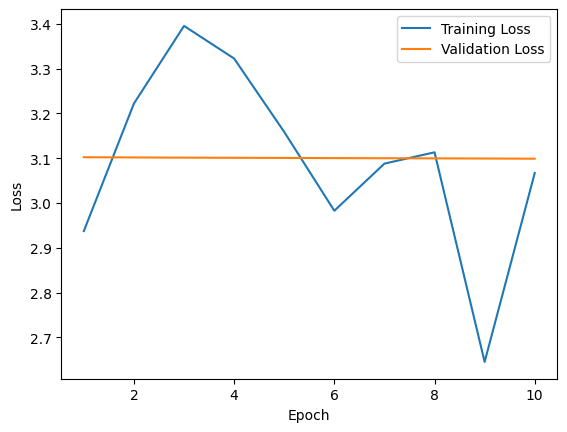

In [180]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tune_model.parameters(), lr=0.00002)
# Training and Validation loop
train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # Training loop
    fine_tune_model.train()
    for train_data in train_dataloader:
        inputs, labels = train_data['pixel_values'], train_data['labels']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = fine_tune_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Cleanup GPU memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()

    # Validation loop
    fine_tune_model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_data in val_dataloader:
        val_inputs, val_labels = val_data['pixel_values'], val_data['labels']
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = fine_tune_model(val_inputs)

        # Extract the logits tensor from ImageClassifierOutput
        logits_tensor = val_outputs.logits

        # Calculate the cross-entropy loss
        val_loss += criterion(logits_tensor, val_labels).item()

        _, predicted = torch.max(logits_tensor, 1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_samples += val_labels.size(0)

        # Cleanup GPU memory
        del val_inputs, val_labels, logits_tensor
        torch.cuda.empty_cache()

    average_val_loss = val_loss / len(val_dataloader)

    # Append training and validation losses to lists
    train_losses.append(loss.item())
    val_losses.append(average_val_loss)

    accuracy = correct_predictions / total_samples

    # Print or log training and validation statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {average_val_loss}, Accuracy: {accuracy}')

# Plotting training and validation losses over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()